# Homework 3
### Daniela del Rio

In [1]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import scipy
from sklearn import mixture

# Part 1

In [2]:
SpikeWaveforms = np.load('SpikeWaveforms.npy', allow_pickle=True)
print(np.shape(SpikeWaveforms))
# AP detected, time, electrode

(33787, 40, 4)


In [3]:
indices = []
Peaks_1 = []
Peaks_2 = []
Peaks_3 = []
Peaks_4 = []
xn_ex2 = []

# Indices for starting and ending
start = 5
end = 25

for i in range(33787): #33787
    
    average_tetrodes = np.zeros(40)

    for time_i in range(40):
        average_tetrodes[time_i] = (np.sum(SpikeWaveforms[i,time_i,0]+SpikeWaveforms[i,time_i,1]+SpikeWaveforms[i,time_i,2]+SpikeWaveforms[i,time_i,3]))/4
        
    index = np.argmax(average_tetrodes)
    
    if start<index and index<end:
        indices.append(index)
        Peaks_1.append(SpikeWaveforms[i, index, 0])
        Peaks_2.append(SpikeWaveforms[i, index, 1])
        Peaks_3.append(SpikeWaveforms[i, index, 2])
        Peaks_4.append(SpikeWaveforms[i, index, 3])
        xn_ex2.append(SpikeWaveforms[i, :, 0])

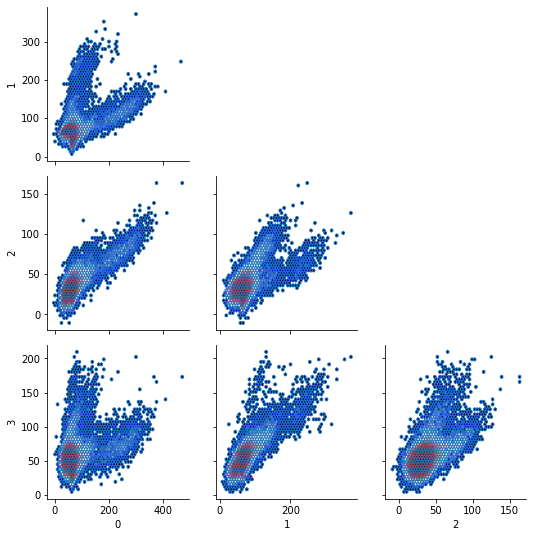

In [4]:
Peaks = [Peaks_1, Peaks_2, Peaks_3, Peaks_4]
Peaks = np.transpose(Peaks)

# Code from class website
PP = pd.DataFrame(np.array(Peaks))
g = sns.PairGrid(PP)
g = g.map_lower(plt.hexbin,gridsize=50, mincnt=1, cmap='seismic',bins='log')
for i, j in zip(*np.triu_indices_from(g.axes, 0)):
    g.axes[i, j].set_visible(False)

# Part 2
## Clustering with K-means

In [5]:
def iterative_cost_function(xns, mk, rnks): # Cost function for 1 cluster
    n = len(xns)
    J = 0
    for i in range(n):
        if rnks[i]: 
            J += np.sum((xns[i]-mk)**2) #Sums all 40 values
    return J

def all_clusters_cost_function(xns, mks, rnks): # Cost function for all clusters
    J = 0
    
    for cluster_i in range(len(mks)):
        J+= iterative_cost_function(xns, mks[cluster_i], rnks[cluster_i])
    return J

In [6]:
# Assigning a cluster based on distance between centroids and points:
def distances(xns, mks):
    number_of_clusters = len(mks) #2000
    number_of_datapoints = len(xns) #3
    
    rnks_1 = np.zeros(number_of_datapoints, dtype = bool)
    rnks_2 = np.zeros(number_of_datapoints, dtype = bool)
    rnks_3 = np.zeros(number_of_datapoints, dtype = bool)
    
    for i in range(number_of_datapoints):
        distance = np.zeros(number_of_clusters)
        
        for cluster_i in range(number_of_clusters):
            distance[cluster_i]= np.sum((xns[i]-mks[cluster_i])**2)
            
        minimum = np.argmin(distance)
        
        if minimum ==0: # Belongs in cluster 1
            rnks_1[i] = 1
        elif minimum ==1: # Belongs in cluster 2
            rnks_2[i] = 1
        elif minimum ==2: # Belongs in cluster 3
            rnks_3[i] = 1
    return rnks_1, rnks_2, rnks_3

In [7]:
def plot_traces(xns, rnks_1, rnks_2, rnks_3, mks):
    fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, figsize=(10,7))
    fig.suptitle('Neuron traces based on cluster', fontsize=20)

    time = [i for i in range(40)]
    for i in range(2000):

        if rnks_1[i]:
            ax1.plot(time, xns[i], marker="o", color="salmon")

        elif rnks_2[i]:
            ax2.plot(time, xns[i], marker="o", color="deeppink")

        elif rnks_3[i]:
            ax3.plot(time, xns[i], marker="o", color="dimgrey")

    ax1.plot(time, mks[0], marker ="o", c="r")
    ax2.plot(time, mks[1], marker ="o", c="purple")
    ax3.plot(time, mks[2], marker ="o", c="k")
    plt.xlabel('Time')
    plt.ylabel("Voltage")
    plt.show()
    return None

In [8]:
# Updating centroids
def updates_centroids(xns, rnks_1, rnks_2, rnks_3):
    c1 = []
    c2 = []
    c3 = []

    for i in range(2000):

        if rnks_1[i]:
            c1.append(xns[i])

        elif rnks_2[i]:
            c2.append(xns[i])

        elif rnks_3[i]:
            c3.append(xns[i])

    mks1 = np.mean(c1, 0)
    mks2 = np.mean(c2, 0)
    mks3 = np.mean(c3, 0)
    
    return mks1, mks2, mks3 

In [9]:
def one_iteration(xns, mks_init):
    rnks_1, rnks_2, rnks_3 = distances(xns, mks_init)
    mks1, mks2, mks3 = updates_centroids(xns, rnks_1, rnks_2, rnks_3)
    
    mks = [mks1, mks2, mks3]
    rnks = [rnks_1, rnks_2, rnks_3]
    
    J = all_clusters_cost_function(xns, mks, rnks)
    return J, rnks, mks

The k-means algorithm stops running when the cost function stops changing, at least when the difference between the last and before last J values change less than $0.001 = 0.1 \%$ of the last J value. Notice this would present a problem if we had a values that kept changing periodically from one cluster to another. 

In [10]:
xns = xn_ex2[:2000] # whole 40 time indices of electrode 1

# Initializes with 3 random traces from the dataset
mks_init = [xns[round(2000*random.random())], xns[round(2000*random.random())], xns[round(2000*random.random())]]
J = []
i = 0
converging = False

J1, rnks_1, mks = one_iteration(xns, mks_init) # First iteration
J.append(J1)

while converging == False:
    J1, rnks, mks = one_iteration(xns, mks)
    J.append(J1)
    
    if np.abs(J[i-1]-J[i])< 0.001*J[i]: # Finding the convergence value
        print("Converging value occurs in the ", i+1, "th iteration.")
        converging = True
    i +=1

Converging value occurs in the  4 th iteration.


### Part a

First clusters


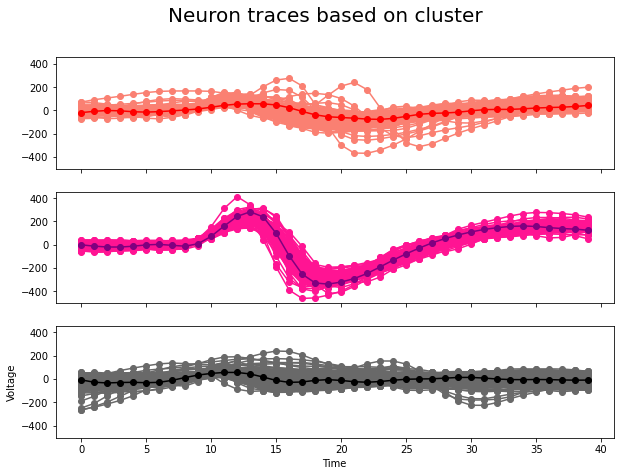

Last clusters


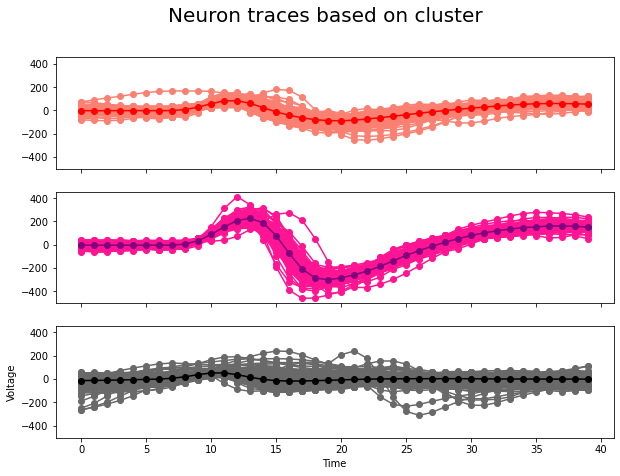

In [11]:
print("First clusters")
plot_traces(xns, rnks_1[0], rnks_1[1], rnks_1[2], mks_init)

print("Last clusters")
plot_traces(xns, rnks[0], rnks[1], rnks[2], mks)

### Part b

Notice in the following plot a horizontal line which corresponds to the last value of J (the converging J value). If we simply discriminate by eye, this convergence is generally reached in iterations 3 to 5. Nevertheless, see the following cells.

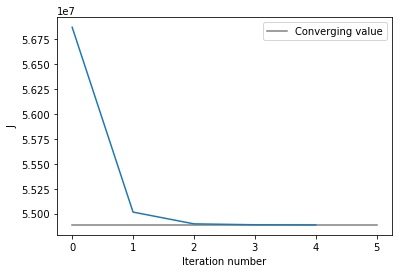

In [12]:
max_ind = len(J)
plt.plot([0,max_ind], [J[max_ind-1], J[max_ind-1]], label = "Converging value", color = "grey")
plt.plot(J)
plt.xlabel("Iteration number")
plt.ylabel("J")
plt.legend()
plt.show()

In [13]:
# Code for finding when the convergence occurs
# We will define convergence as the value when the difference between 2 iterations is less than 0.001
# of the last iteration value

converging_values = np.zeros(10)

xns = xn_ex2[:2000] # whole 40 time indices of electrode 1

# Running the simulation 10 times,
for simulation_i in range(10):
    # Initializes with 3 random traces from the dataset
    mks_init = [xns[round(2000*random.random())], xns[round(2000*random.random())], xns[round(2000*random.random())]]
    J = []
    i = 0
    converging = False

    J1, rnks_1, mks = one_iteration(xns, mks_init) # First iteration
    J.append(J1)
    
    while converging == False:
        J1, rnks, mks = one_iteration(xns, mks)
        J.append(J1)

        if np.abs(J[i-1]-J[i])< 0.001*J[i]: # Finding the convergence value
            converging_values[simulation_i] = i+1
            converging = True
        i +=1
        
print(converging_values)
print(np.mean(converging_values))

[ 7.  5.  7. 10.  6.  5. 11.  7.  6.  8.]
7.2


In the previuos cell we iterated the K-means algorithm several times and found that the mean convergence time of the algorithm with $K=3$ is 5.1 iterations.

### Part c
Using 4 clusters.

In [14]:
# Assigning a cluster based on distance between centroids and points:
def distances_4(xns, mks):
    number_of_clusters = len(mks) #2000
    number_of_datapoints = len(xns) #3
    
    rnks_1 = np.zeros(number_of_datapoints, dtype = bool)
    rnks_2 = np.zeros(number_of_datapoints, dtype = bool)
    rnks_3 = np.zeros(number_of_datapoints, dtype = bool)
    rnks_4 = np.zeros(number_of_datapoints, dtype = bool)
    
    for i in range(number_of_datapoints):
        distance = np.zeros(number_of_clusters)
        
        for cluster_i in range(number_of_clusters):
            distance[cluster_i]= np.sum((xns[i]-mks[cluster_i])**2)
            
        minimum = np.argmin(distance)
        
        if minimum ==0: # Belongs in cluster 1
            rnks_1[i] = 1
        elif minimum ==1: # Belongs in cluster 2
            rnks_2[i] = 1
        elif minimum ==2: # Belongs in cluster 3
            rnks_3[i] = 1
        elif minimum ==3: # Belongs in cluster 3
            rnks_4[i] = 1
    return rnks_1, rnks_2, rnks_3, rnks_4

def plot_traces_4(xns, rnks_1, rnks_2, rnks_3, rnks_4, mks):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, sharey=True, figsize=(10,7))
    fig.suptitle('Neuron traces based on cluster', fontsize=20)

    time = [i for i in range(40)]
    for i in range(2000):

        if rnks_1[i]:
            ax1.plot(time, xns[i], marker="o", color="salmon")

        elif rnks_2[i]:
            ax2.plot(time, xns[i], marker="o", color="deeppink")

        elif rnks_3[i]:
            ax3.plot(time, xns[i], marker="o", color="dimgrey")

        elif rnks_4[i]:
            ax4.plot(time, xns[i], marker="o", color="lightblue")

    ax1.plot(time, mks[0], marker ="o", c="r")
    ax2.plot(time, mks[1], marker ="o", c="purple")
    ax3.plot(time, mks[2], marker ="o", c="k")
    ax4.plot(time, mks[3], marker ="o", c="b")
    plt.xlabel('Time')
    plt.ylabel("Voltage")
    plt.show()
    return None

# Updating centroids
def updates_centroids_4(xns, rnks_1, rnks_2, rnks_3, rnks_4):
    c1 = []
    c2 = []
    c3 = []
    c4 = []

    for i in range(2000):

        if rnks_1[i]:
            c1.append(xns[i])

        elif rnks_2[i]:
            c2.append(xns[i])

        elif rnks_3[i]:
            c3.append(xns[i])

        elif rnks_4[i]:
            c4.append(xns[i])

    mks1 = np.mean(c1, 0)
    mks2 = np.mean(c2, 0)
    mks3 = np.mean(c3, 0)
    mks4 = np.mean(c4, 0)
    
    return mks1, mks2, mks3, mks4

def one_iteration_4(xns, mks_init):
    rnks_1, rnks_2, rnks_3, rnks_4 = distances_4(xns, mks_init)
    mks1, mks2, mks3, mks4 = updates_centroids_4(xns, rnks_1, rnks_2, rnks_3, rnks_4)
    
    mks = [mks1, mks2, mks3, mks4]
    rnks = [rnks_1, rnks_2, rnks_3, rnks_4]
    
    J = all_clusters_cost_function(xns, mks, rnks)
    return J, rnks, mks

In [15]:
# Update for using 4 centroids

xns = xn_ex2[:2000] # whole 40 time indices of electrode 1

# Initializes with 4 random traces from the dataset
mks_init = [xns[round(2000*random.random())], xns[round(2000*random.random())], xns[round(2000*random.random())], xns[round(2000*random.random())]]
J = []
i = 0
converging = False

J1, rnks_1, mks = one_iteration_4(xns, mks_init) # First iteration
J.append(J1)

while converging == False:
    J1, rnks, mks = one_iteration_4(xns, mks)
    J.append(J1)
    
    if np.abs(J[i-1]-J[i])< 0.001*J[i]: # Finding the convergence value
            print("Converging value is: ", i+1, "th iteration.")
            break
    i +=1

Converging value is:  9 th iteration.


First clusters


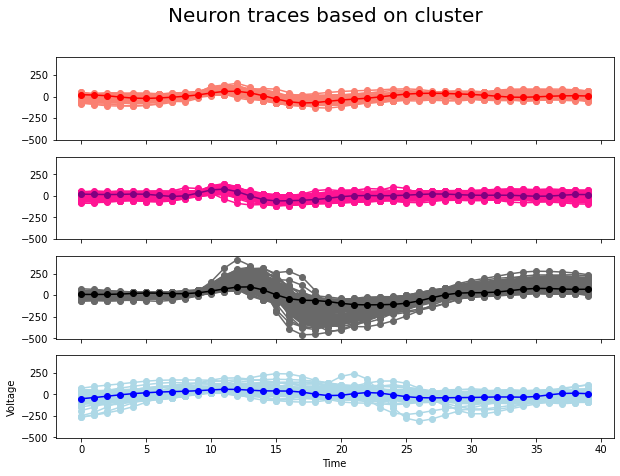

Last clusters


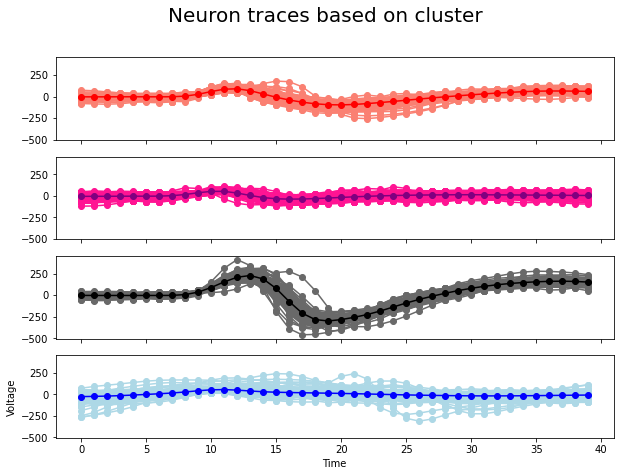

In [16]:
print("First clusters")
plot_traces_4(xns, rnks_1[0], rnks_1[1], rnks_1[2], rnks[3], mks_init)

print("Last clusters")
plot_traces_4(xns, rnks[0], rnks[1], rnks[2], rnks[3], mks)

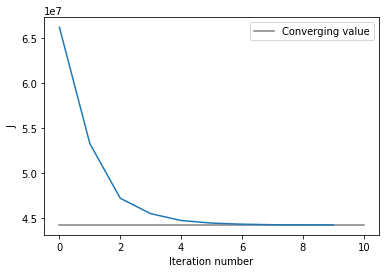

In [17]:
max_ind = len(J)
plt.plot([0,max_ind], [J[max_ind-1], J[max_ind-1]], label = "Converging value", color = "grey")
plt.plot(J)
plt.xlabel("Iteration number")
plt.ylabel("J")
plt.legend()
plt.show()

In [18]:
# Code for finding when the convergence occurs
# We will define convergence as the value when the difference between 2 iterations is less than 0.001
# of the last iteration value

converging_values = np.zeros(10)

xns = xn_ex2[:2000] # whole 40 time indices of electrode 1

# Running the simulation 10 times,
for simulation_i in range(10):
    # Initializes with 4 random traces from the dataset
    mks_init = [xns[round(2000*random.random())], xns[round(2000*random.random())], xns[round(2000*random.random())], xns[round(2000*random.random())]]
    J = []
    i = 0
    converging = False

    J1, rnks_1, mks = one_iteration_4(xns, mks_init) # First iteration
    J.append(J1)
    
    while converging == False:
        J1, rnks, mks = one_iteration_4(xns, mks)    
        J.append(J1)
        
        if np.abs(J[i-1]-J[i])< 0.001*J[i]: # Finding the convergence value
            converging_values[simulation_i] = i
            converging = True
        i+=1

Notice how it takes more iterations of the K-means algorithm to converge when using a bigger amount of clusters.

Stop iterating when cost function does not change or when the assignments don't change.

https://en.wikipedia.org/wiki/K-means_clustering

https://quick-adviser.com/how-do-you-implement-k-means/

# Part 4
## Using Gaussian mixtures

In [19]:
# Code from homework assignment
gmix = mixture.GaussianMixture(n_components=2, covariance_type='full')
gmix.fit(Peaks)

GaussianMixture(n_components=2)

In [20]:
SpikeWaveforms = np.load('SpikeWaveforms12.npy', allow_pickle=True)
print(np.shape(SpikeWaveforms))
# AP detected, time, electrode

(16789, 40, 4)


In [22]:
indices = []
Peaks_1 = []
Peaks_2 = []
Peaks_3 = []
Peaks_4 = []
xn_ex2 = []

# Indices for starting and ending
start = 5
end = 25

for i in range(16789): #16789
    
    average_tetrodes = np.zeros(40)

    for time_i in range(40):
        average_tetrodes[time_i] = (np.sum(SpikeWaveforms[i,time_i,0]+SpikeWaveforms[i,time_i,1]+SpikeWaveforms[i,time_i,2]+SpikeWaveforms[i,time_i,3]))/4
        
    index = np.argmax(average_tetrodes)
    
    if start<index and index<end:
        indices.append(index)
        Peaks_1.append(SpikeWaveforms[i, index, 0])
        Peaks_2.append(SpikeWaveforms[i, index, 1])
        Peaks_3.append(SpikeWaveforms[i, index, 2])
        Peaks_4.append(SpikeWaveforms[i, index, 3])
        xn_ex2.append(SpikeWaveforms[i, :, 0])

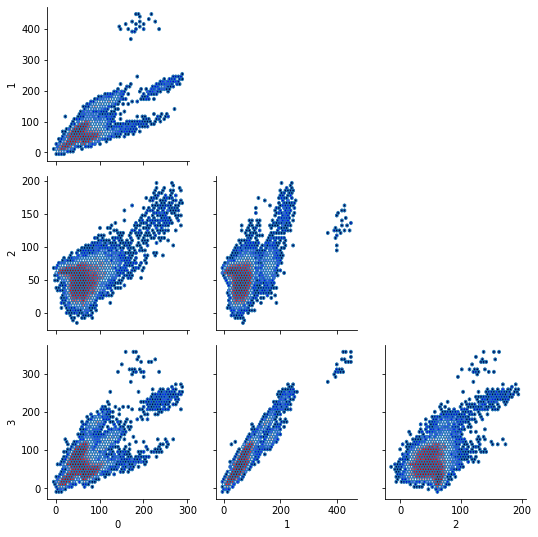

In [23]:
Peaks = [Peaks_1, Peaks_2, Peaks_3, Peaks_4]
Peaks = np.transpose(Peaks)

# Code from class website
PP = pd.DataFrame(np.array(Peaks))
g = sns.PairGrid(PP)
g = g.map_lower(plt.hexbin,gridsize=50, mincnt=1, cmap='seismic',bins='log')
for i, j in zip(*np.triu_indices_from(g.axes, 0)):
    g.axes[i, j].set_visible(False)

In [25]:
len(Peaks)

14999

# The problem is that these peak data are only of electrode 1, must we also consider the other 3? And if such, how to train the model with this data?

# Part 5
## Clustering using Pearson Correlation

This problem replicates a result from the paper “Sub-second dynamics of theta-gamma coupling in hippocampal CA1” by Zhang et al https://elifesciences.org/articles/44320. They calculated the spectrograms of their LFP data and extracted individual theta cycles. They then clustered these spectrograms to assess whether higher frequency gamma oscillations preferentially occur at certain phases of theta.

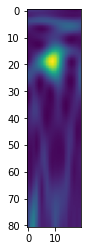

In [27]:
data = np.load('hw4problem5.npy')
plt.imshow(data[0,:,:])

In [29]:
np.shape(data)

(3900, 81, 20)

In [ ]:
phase = np.linspace(-np.pi, np.pi, 20) # phase
freqs = np.arange(20, 182, 2)[::-1] # frequency vector
# in the frequency vector and the data, the 0-th entry corresponds to the highest frequency (180 Hz)